# NSFP Agent

In [17]:
import rlcard
from rlcard.agents.nfsp_agent import NFSPAgent
from rlcard.agents import RandomAgent
from rlcard.utils import tournament, Logger, plot_curve
import torch

import numpy as np
import collections
import os
import pickle

import rlcard
from rlcard.utils.utils import remove_illegal
from rlcard.agents import CFRAgent, RandomAgent, DQNAgent
from rlcard.utils import tournament, Logger, plot_curve

from sklearn.cluster import KMeans

## NSFP (Original)


----------------------------------------
  episode      |  1
  reward       |  0.026
----------------------------------------
Episode 49
----------------------------------------
  episode      |  133
  reward       |  -0.00455
----------------------------------------
Episode 99
----------------------------------------
  episode      |  270
  reward       |  0.01575
----------------------------------------
Episode 149
----------------------------------------
  episode      |  381
  reward       |  -0.00785
----------------------------------------
Episode 199
----------------------------------------
  episode      |  523
  reward       |  0.02635
----------------------------------------
Episode 249
----------------------------------------
  episode      |  650
  reward       |  0.04585
----------------------------------------
Episode 299
----------------------------------------
  episode      |  786
  reward       |  0.0134
----------------------------------------
Episode 349
----------

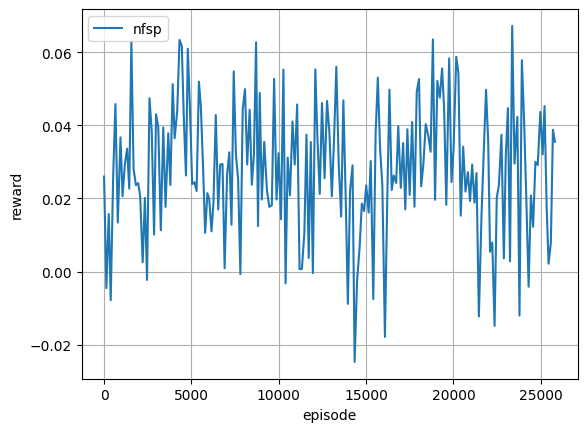

In [11]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})
eval_env = rlcard.make('leduc-holdem')

initial_states = env.reset()
example_state = initial_states[0]['obs']
state_shape = example_state.shape

nfsp_agent = NFSPAgent(
    num_actions=env.num_actions,
    state_shape=state_shape,
    hidden_layers_sizes=[128, 128],
    q_mlp_layers=[64, 64],
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
)

eval_env.set_agents([nfsp_agent, RandomAgent(num_actions=env.num_actions)])

with Logger("experiments/leduc_holdem_nfsp_result") as logger:
    num_episodes = 10000
    for episode in range(num_episodes):
        env.reset()
        while not env.is_over():
            current_player = env.get_player_id()
            state = env.get_state(current_player)
            action = nfsp_agent.step(state)
            env.step(action)
        if episode % 50 == 0:
            performance = tournament(eval_env, 10000)[0]
            logger.log_performance(env.timestep, performance)
        print(f'\rEpisode {episode}', end='')

    csv_path, fig_path = logger.csv_path, logger.fig_path

# Plot the performance curve
plot_curve(csv_path, fig_path, 'nfsp')


In [13]:
def compare_models(env_name, model1, model1_name, model2, model2_name, num_games=10000):
    """
    Compare two agents by swapping their seating positions and averaging results.
    """
    # Create a fresh evaluation environment
    eval_env = rlcard.make(env_name)
    
    # First seating: model1 as player 0, model2 as player 1
    eval_env.set_agents([model1, model2])
    rewards_order1 = tournament(eval_env, num_games)
    
    # Second seating: model2 as player 0, model1 as player 1
    eval_env.set_agents([model2, model1])
    rewards_order2 = tournament(eval_env, num_games)
    
    avg_reward_model1 = (rewards_order1[0] + rewards_order2[1]) / 2.0
    avg_reward_model2 = (rewards_order1[1] + rewards_order2[0]) / 2.0
    
    print(f"Average reward for {model1_name}: {avg_reward_model1:.4f}")
    print(f"Average reward for {model2_name}: {avg_reward_model2:.4f}")
    
    return avg_reward_model1, avg_reward_model2

In [14]:
class StateAbstraction:
    def __init__(self, n_clusters=100):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        self.fitted = False

    def fit(self, state_samples):
        """
        Fit the clustering model on a collection of state samples.
        """
        self.kmeans.fit(state_samples)
        self.fitted = True

    def abstract_state(self, state):
        """
        Map a raw state (numeric vector) into its abstract state label.
        """
        if not self.fitted:
            raise ValueError("StateAbstraction model is not fitted. Call fit() with state samples first.")
        state = np.array(state).reshape(1, -1)
        label = self.kmeans.predict(state)[0]
        return str(label)

class CFRPlusAgentWithBaselineAbstract():
    """
    CFR+ agent with baseline variance reduction and state abstraction.
    This agent uses a clustering mechanism (KMeans) to compress the state space.
    """
    def __init__(self, env, model_path='./cfr_model', n_clusters=100):
        self.use_raw = False
        self.env = env
        self.model_path = model_path

        # Dictionaries to hold the tabular values.
        self.policy = collections.defaultdict(list)
        self.average_policy = collections.defaultdict(lambda: np.zeros(env.num_actions))
        self.regrets = collections.defaultdict(lambda: np.zeros(env.num_actions))
        self.baselines = collections.defaultdict(float)
        self.iteration = 0

        # Initialize state abstraction.
        self.abstraction = StateAbstraction(n_clusters=n_clusters)

    def train(self):
        """Perform one iteration of CFR+ with baseline and state abstraction."""
        self.iteration += 1
        for player_id in range(self.env.num_players):
            self.env.reset()
            probs = np.ones(self.env.num_players)
            self.traverse_tree(probs, player_id)
        self.update_policy()

    def traverse_tree(self, probs, player_id):
        if self.env.is_over():
            return self.env.get_payoffs()

        current_player = self.env.get_player_id()
        action_utilities = {}
        state_utility = np.zeros(self.env.num_players)
        # Use abstract state instead of raw state
        obs, legal_actions = self.get_state(current_player)
        action_probs = self.action_probs(obs, legal_actions, self.policy)

        for action in legal_actions:
            act_prob = action_probs[action]
            new_probs = probs.copy()
            new_probs[current_player] *= act_prob

            self.env.step(action)
            utility = self.traverse_tree(new_probs, player_id)
            self.env.step_back()

            state_utility += act_prob * utility
            action_utilities[action] = utility

        if current_player != player_id:
            return state_utility

        player_prob = probs[current_player]
        counterfactual_prob = (np.prod(probs[:current_player]) *
                               np.prod(probs[current_player+1:]))
        player_state_utility = state_utility[current_player]

        # Update baseline for this abstract state
        prev_baseline = self.baselines[obs]
        self.baselines[obs] = ((prev_baseline * (self.iteration - 1)) + player_state_utility) / self.iteration

        for action in legal_actions:
            act_prob = action_probs[action]
            regret = counterfactual_prob * (action_utilities[action][current_player] - self.baselines[obs])
            self.regrets[obs][action] = max(0, self.regrets[obs][action] + regret)
            self.average_policy[obs][action] += self.iteration * player_prob * act_prob

        return state_utility

    def update_policy(self):
        for obs in self.regrets:
            self.policy[obs] = self.regret_matching(obs)

    def regret_matching(self, obs):
        regret = self.regrets[obs]
        regret_plus = np.maximum(regret, 0)
        total_positive = regret_plus.sum()
        action_probs = np.zeros(self.env.num_actions)
        if total_positive > 0:
            action_probs = regret_plus / total_positive
        else:
            action_probs.fill(1.0 / self.env.num_actions)
        return action_probs

    def action_probs(self, obs, legal_actions, policy):
        if obs not in policy:
            action_probs = np.array([1.0 / self.env.num_actions for _ in range(self.env.num_actions)])
            self.policy[obs] = action_probs
        else:
            action_probs = policy[obs]
        action_probs = remove_illegal(action_probs, legal_actions)
        return action_probs

    def eval_step(self, state):
        # In evaluation, obtain the raw state (assumed to be a numpy array), flatten it, and abstract.
        raw_state = state['obs'] 
        numeric_state = raw_state.flatten()
        try:
            abstract_state = self.abstraction.abstract_state(numeric_state)
        except ValueError:
            abstract_state = raw_state.tobytes()  # fallback if not fitted
        legal_actions = list(state['legal_actions'].keys())
        probs = self.action_probs(abstract_state, legal_actions, self.average_policy)
        action = np.random.choice(len(probs), p=probs)
        info = {
            'probs': {state['raw_legal_actions'][i]: float(probs[list(state['legal_actions'].keys())[i]])
                      for i in range(len(state['legal_actions']))}
        }
        return action, info

    def get_state(self, player_id):
        state = self.env.get_state(player_id)
        # Assume state['obs'] is a numpy array; flatten to a 1D vector.
        numeric_state = state['obs'].flatten()
        try:
            abstract_state = self.abstraction.abstract_state(numeric_state)
        except ValueError:
            # If abstraction not yet fitted, fall back to raw bytes (or consider raising an error)
            abstract_state = state['obs'].tobytes()
        legal_actions = list(state['legal_actions'].keys())
        return abstract_state, legal_actions

    def save(self):
        if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)
        with open(os.path.join(self.model_path, 'policy.pkl'), 'wb') as f:
            pickle.dump(self.policy, f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'wb') as f:
            pickle.dump(self.average_policy, f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'wb') as f:
            pickle.dump(self.regrets, f)
        with open(os.path.join(self.model_path, 'baseline.pkl'), 'wb') as f:
            pickle.dump(self.baselines, f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'wb') as f:
            pickle.dump(self.iteration, f)
        with open(os.path.join(self.model_path, 'abstraction.pkl'), 'wb') as f:
            pickle.dump(self.abstraction, f)

    def load(self):
        if not os.path.exists(self.model_path):
            return
        with open(os.path.join(self.model_path, 'policy.pkl'), 'rb') as f:
            self.policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'average_policy.pkl'), 'rb') as f:
            self.average_policy = pickle.load(f)
        with open(os.path.join(self.model_path, 'regrets.pkl'), 'rb') as f:
            self.regrets = pickle.load(f)
        with open(os.path.join(self.model_path, 'baseline.pkl'), 'rb') as f:
            self.baselines = pickle.load(f)
        with open(os.path.join(self.model_path, 'iteration.pkl'), 'rb') as f:
            self.iteration = pickle.load(f)
        with open(os.path.join(self.model_path, 'abstraction.pkl'), 'rb') as f:
            self.abstraction = pickle.load(f)


In [30]:
env = rlcard.make('leduc-holdem', config={'allow_step_back': True})

cfr_agent = CFRAgent(env, "experiments/leduc_holdem_cfr_result/cfr_model")
cfr_agent.load()

compare_models('leduc-holdem', nfsp_agent, "nfsp_agent", cfr_agent, "CFR+", num_games=1000)

Average reward for nfsp_agent: -0.0263
Average reward for CFR+: 0.0263


(np.float64(-0.026250000000000002), np.float64(0.026250000000000002))